In [24]:
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import torch
import torch.nn as nn

from New_Project import *

In [25]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

file = 'cifar_test_nolabels.pkl'
data = unpickle(file)

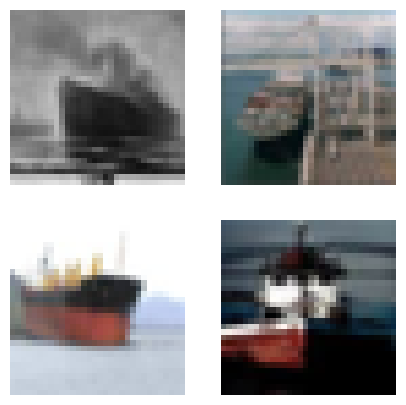

In [26]:
def Toimage(data):
    image_dict = {}
    for i,e in enumerate(data[b'data']):
        red_channel = e[:1024]
        green_channel = e[1024:2048]
        blue_channel = e[2048:]

        image_data = np.zeros((32, 32, 3), dtype=np.uint8)
        image_data[:,:,0] = np.reshape(red_channel, (32, 32))   # Red channel
        image_data[:,:,1] = np.reshape(green_channel, (32, 32)) # Green channel
        image_data[:,:,2] = np.reshape(blue_channel, (32, 32))  # Blue channel

        image_dict[i] = image_data
    return image_dict


image_dict = Toimage(data)

pic_num = 4

rows = int(np.sqrt(pic_num))
cols = int(np.sqrt(pic_num))
fig = plt.figure(figsize = (5, 5))
for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    image = image_dict[i]
    ax.imshow(image)

    ax.axis('off')

In [27]:
class CustomCIFAR10Dataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Extract and reshape the image data for the given index
        image = self.data[idx].reshape(3, 32, 32)  # Reshape to (3, 32, 32) for RGB format
        image = image.transpose((1, 2, 0))  # Convert from (3, 32, 32) to (32, 32, 3) for PIL compatibility
        image = transforms.ToTensor()(image)  # Convert to PyTorch tensor and normalize

        return image


In [41]:
dataset = CustomCIFAR10Dataset(image_dict)
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')


args = parse_args()
model = ResNetModel(args, train=False)
model.load_model('./final_0406214550.pth')

pred_labels = []
with torch.no_grad():
    for images in dataloader:
        images = images.to(device)
        outputs = model.net(images)
        _, predicted = torch.max(outputs.data, 1)
        pred_labels += predicted.tolist()



model loaded from ./final_0406214550.pth


In [42]:
import csv

def write_lists_to_csv(list1, list2, csv_filename):
    # Ensure the lengths of both lists are the same
    if len(list1) != len(list2):
        raise ValueError("The lengths of the input lists must be the same.")

    # Create or open the CSV file in write mode
    with open(csv_filename, 'w', newline='') as csvfile:
        # Define the header names for the columns
        fieldnames = ['ID', 'Labels']

        # Create a CSV writer object
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        # Write the header (column names) to the CSV file
        writer.writeheader()

        # Write rows to the CSV file based on the lists
        for id_value, label_value in zip(list1, list2):
            writer.writerow({'ID': id_value, 'Labels': label_value})

# Example lists of IDs and Labels
ids = [i for i in range(10000)]


# Specify the CSV filename
csv_filename = 'output.csv'

# Call the function to write lists to CSV
write_lists_to_csv(ids, pred_labels, csv_filename)

print(f"CSV file '{csv_filename}' has been created successfully.")


CSV file 'output.csv' has been created successfully.
